# 1. Getting VizDoom Up and Running

In [2]:
!pip install vizdoom

In [3]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

fatal: destination path 'ViZDoom' already exists and is not an empty directory.


In [14]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [ ]:
# Setup game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/deadly_corridor_s1.cfg')
game.init()

In [16]:
# This is the set of actions we can take in the environment
actions = np.identity(7, dtype=np.uint8)

In [17]:
state = game.get_state()

In [18]:
state.game_variables

array([100.,   0.,   0.,  -1.])

In [74]:
# Loop through episodes 
episodes = 2
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

In [10]:
game.close()

# 2. Converting it to a Gym Environment

In [11]:
!pip install gym

In [12]:
!pip install opencv-python

In [13]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [58]:
#game.get_state().screen_buffer.shape

In [55]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False, config = 'github/VizDoom/scenarios/deadly_corridor_s1.cfg'): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(7)
        
        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52 ## CHANGED
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) 
        
        reward = 0 
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            # Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200  + ammo_delta*5 
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [28]:
env = VizDoomGym(render=True)

In [22]:
state = env.reset()

# 3. View Game State

In [23]:
env.reset()

array([[[32],
        [33],
        [25],
        ...,
        [27],
        [23],
        [24]],

       [[27],
        [33],
        [23],
        ...,
        [24],
        [24],
        [24]],

       [[20],
        [35],
        [23],
        ...,
        [24],
        [24],
        [24]],

       ...,

       [[75],
        [63],
        [62],
        ...,
        [44],
        [71],
        [60]],

       [[15],
        [48],
        [47],
        ...,
        [49],
        [69],
        [47]],

       [[22],
        [14],
        [26],
        ...,
        [57],
        [37],
        [39]]], dtype=uint8)

In [31]:
env.close()

In [27]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [33]:
#env_checker.check_env(env)

# 3. View State

In [34]:
!pip install matplotlib

In [35]:
from matplotlib import pyplot as plt

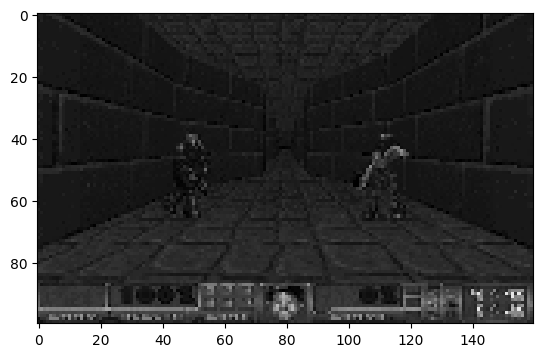

In [36]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# 4. Setup Callback

In [37]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [38]:
!pip install stable-baselines3[extra]

In [39]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [56]:
# Import os for file nav
import os 


In [57]:
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [58]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [59]:
CHECKPOINT_DIR = './train/train_run'
LOG_DIR = './logs/log_run'

In [60]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 5. Train Model using curriculum

In [65]:
# import ppo for training
from stable_baselines3 import PPO

In [66]:
# Non rendered environment
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_s1.cfg')

In [67]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [68]:
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_run\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 206      |
|    ep_rew_mean     | 74.5     |
| time/              |          |
|    fps             | 54       |
|    iterations      | 1        |
|    time_elapsed    | 151      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 175          |
|    ep_rew_mean          | 127          |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 2            |
|    time_elapsed         | 246          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0034785308 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_variance   

KeyboardInterrupt: 

# 6. Test the Model

In [69]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [71]:
# Reload model from disc
model = PPO.load('./train/train_run/best_model_340000')

In [72]:
# Create rendered environment
env = VizDoomGym(render=True)

In [73]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\Omkar\Anaconda3\envs\my_env_3913\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [55]:
mean_reward

14.1

In [56]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total Reward for episode 6.0 is 0
Total Reward for episode 7.0 is 1
Total Reward for episode 8.0 is 2
Total Reward for episode 13.0 is 3
Total Reward for episode 9.0 is 4
Total Reward for episode 9.0 is 5
Total Reward for episode 11.0 is 6
Total Reward for episode 8.0 is 7
Total Reward for episode 8.0 is 8
Total Reward for episode 7.0 is 9


In [55]:
model.predict(obs)

(array(1, dtype=int64), None)